In [1]:
!nvidia-smi

Sat Sep 18 16:31:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8     8W /  N/A |    990MiB /  5934MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers datasets

In [3]:
import torch
import random
import numpy as np
import time
import datetime
import seaborn as sns
import pandas as pd
import os
import pathlib
import json
import math
import re
from random import randrange
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, GPTNeoForCausalLM
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import Trainer, TrainingArguments

In [4]:
seed = random.randint(0, 2 ** 32 - 1)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 177829170


In [5]:
if os.path.isdir("/opt/awsw"):
  # In case we run this locally (in Docker)
  work_dir = os.path.join("/opt", "awsw")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  work_dir = os.path.join("/content", "drive", "MyDrive", "endless_awsw")

models_dir = os.path.join(work_dir, "models")

if not os.path.isdir(models_dir):
    pathlib.Path(models_dir).mkdir(parents=True, exist_ok=True)
    
tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
# model = GPT2LMHeadModel.from_pretrained('EleutherAI/gpt-neo-125M', pad_token_id = tokenizer.pad_token_id)
model = GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M', pad_token_id = tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
model.config.attention_dropout = 0.1
model.config.embed_dropout = 0.1
print(f"Loading empty, pre-trained model.")

model.to(device)
model.resize_token_embeddings(len(tokenizer))
print(f"Model attached to {device_name}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading empty, pre-trained model.
Model attached to cuda:0


# Split data

In [6]:
with open(os.path.join(work_dir, "awsw_story_input.txt")) as f:
    data = f.read()
lines = data.split("\n")
player_dragon_pairs = {}
last_player_talk = []
closed_player_talk = False
re_player_talk = re.compile(r'c "(.*?)"')
for line in lines:
    line = line.strip()
    line_split = line.split(" ")
    if len(line_split) <= 1:
        continue
    
    if line_split[0] == "c":
        if closed_player_talk:
            closed_player_talk = False
            last_player_talk = []
        last_player_talk.append(re.sub(re_player_talk, r"\1", line))
    else:
        if not closed_player_talk:
            last_player_talk = json.dumps(last_player_talk)
            if not last_player_talk in player_dragon_pairs:
                player_dragon_pairs[last_player_talk] = []
            closed_player_talk = True
            
        line = "DragonReply " + line
        if last_player_talk is not None:
            player_dragon_pairs[last_player_talk].append(line)
    
train_lines = []
eval_lines = []
eval_per_character = 0

for player_line_str in player_dragon_pairs.keys():
    player_lines = json.loads(player_line_str)
    dragon_lines = player_dragon_pairs[player_line_str]
    compiled_line = " ".join([f'PlayerReply c "{player_line}"' for player_line in player_lines]) + " " + " ".join(dragon_lines)
    train_lines.append(compiled_line)
    
test_bucket = {}
for l in train_lines:
    l_split = l.split(" ")
    character = None
    for i, ls in enumerate(l_split):
        if ls == "DragonReply":
            character = l_split[i + 1]
            break
    if not character in test_bucket:
        test_bucket[character] = []
    test_bucket[character].append(l)
    
for i in range(eval_per_character):
    for character in test_bucket.keys():
        random_line = test_bucket[character][randrange(len(test_bucket[character]))]
        eval_lines.append(random_line)
        for i2, t in enumerate(train_lines):
            if t == random_line:
                del train_lines[i2]
                break
    
joined_eval_lines = "\n".join(eval_lines[:5])
print(f"eval_lines: {joined_eval_lines}")
joined_train_lines = "\n".join(train_lines[:5])
print(f"train_lines: {joined_train_lines}")

if not os.path.isfile(os.path.join(work_dir, "data_train.txt")):
    with open(os.path.join(work_dir, "data_train.txt"), "w") as f:
        for l in train_lines:
            f.write(l + "\n")
            
if not os.path.isfile(os.path.join(work_dir, "data_test.txt")):
    with open(os.path.join(work_dir, "data_test.txt"), "w") as f:
        for l in eval_lines:
            f.write(l + "\n")

eval_lines: 
train_lines: PlayerReply c "Hey, Remy!" DragonReply Ry "Hello, [player_name]."
PlayerReply c "Is there any particular reason why you wanted to meet here?" DragonReply Ry "I enjoy Tatsu Park is all. Have you been here before?"
PlayerReply c "Can't say I have." PlayerReply c "A few times." PlayerReply c "Once or twice." DragonReply Ry "I see." DragonReply Ry "Well, what do you think of it?"
PlayerReply c "It's pretty idyllic." DragonReply Ry smile "It is. I like it a lot here."
PlayerReply c "It's pretty romantic." DragonReply Ry shy "You think so?"


In [7]:
from datasets import load_dataset
dataset = load_dataset('text', data_files={'train': os.path.join(work_dir, "data_train.txt"), 'test': os.path.join(work_dir, "data_test.txt")})
def encode(batch):
    encoded = tokenizer([f"{text}<|endoftext|>" for text in batch['text']])
    return encoded

def group_texts(examples):
    # Make a max size
    block_size = 128
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Pad the end
    to_add = (math.ceil(total_length / block_size) * block_size) - total_length
    if to_add > 0:
        concatenated_examples['input_ids'] += [tokenizer.pad_token_id] * to_add
        concatenated_examples['attention_mask'] += [0] * to_add
        total_length += to_add
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

def map_dragon_reply_text(batch):
    # Make a max size
    block_size = 128
    result = {'text': []}
    for item in batch['text']:
        item_split = item.split(" ")
        player_replies = []
        dragon_replies = []
        current_reply = []
        handling_reply = None
        for token in item_split:
            if token == "PlayerReply":
                if handling_reply is None:
                    handling_reply = "PlayerReply"
                else:
                    if handling_reply == "PlayerReply":
                        # We need to store the PlayerReply
                        player_replies.append(" ".join(current_reply))
                        current_reply = []
            elif token == "DragonReply":
                if handling_reply == "DragonReply":
                    # We need to store the DragonReply
                    dragon_replies.append(" ".join(current_reply))
                    current_reply = []
                    
                if handling_reply == "PlayerReply":
                    # We need to store the PlayerReply
                    player_replies.append(" ".join(current_reply))
                    current_reply = []
                    
                handling_reply = "DragonReply"
                current_reply = []
                    
            if handling_reply is not None:
                current_reply.append(token)
                
        # There's always a dragon reply at the end.
        dragon_replies.append(" ".join(current_reply))
        for player_idx in range(len(player_replies)):
            for dragon_idx in range(len(dragon_replies)):
                result['text'].append(player_replies[player_idx] + " " + dragon_replies[dragon_idx])
                
    return result

dataset_map_cores = min(multiprocessing.cpu_count(), 10)
dataset_batch_size = 1000

dataset = dataset.map(
    map_dragon_reply_text,
    batched=True,
    batch_size=dataset_batch_size,
    num_proc=dataset_map_cores
)

dataset = dataset.map(
    encode,
    batched=True,
    batch_size=dataset_batch_size,
    remove_columns=["text"],
    num_proc=dataset_map_cores
)

dataset = dataset.map(
    group_texts,
    batched=True,
    batch_size=dataset_batch_size,
    num_proc=dataset_map_cores
)

print(tokenizer.decode(dataset['train'][-1]['input_ids'], skip_special_tokens=False))
print(dataset['train'][-1]['attention_mask'])

Using custom data configuration default-d43c312ad1fd98ea
Reusing dataset text (/home/awsw-dev/.cache/huggingface/datasets/text/default-d43c312ad1fd98ea/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)


Reply Ad normal b "I suppose you'll just have to spend the night then."<|endoftext|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [8]:
batch_size = 5
train_len = len(dataset['train'])
num_training_steps = math.ceil(train_len / batch_size)
num_epoch = 10
num_total_steps = num_training_steps * num_epoch
num_warmup_steps = num_training_steps * 2
print(f"num_training_steps: {num_training_steps} num_total_steps: {num_total_steps}")
def get_optimizer_and_scheduler():
    optimizer = AdamW(model.parameters())
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_total_steps)
    return optimizer, scheduler

num_training_steps: 923 num_total_steps: 9230


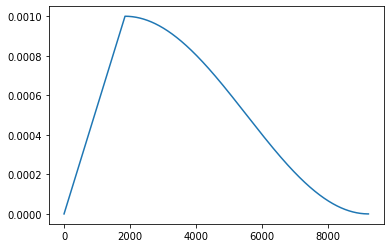

In [9]:
lrs = []
optimizer, scheduler = get_optimizer_and_scheduler()
for i in range(num_total_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.plot(lrs)
plt.show()
del lrs
del optimizer
del scheduler

In [ ]:
def train(model):
    optimizer, scheduler = get_optimizer_and_scheduler()
    training_args = TrainingArguments(
        models_dir,
        seed=seed,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epoch,
        save_total_limit=2,
        save_steps=500,
        logging_steps=250
    )
    trainer = Trainer(
        model=model, 
        args=training_args, 
        train_dataset=dataset['train'], 
        #eval_dataset=dataset['test'],
        optimizers=(optimizer, scheduler)
    )
    checkpoint_dirs = [os.path.join(models_dir, d) for d in os.listdir(models_dir) if os.path.isdir(os.path.join(models_dir, d))]
    if len(checkpoint_dirs) > 0:
        latest_checkpoint = max(checkpoint_dirs, key=os.path.getmtime)
        trainer.train(latest_checkpoint)
    else:
        trainer.train()

train(model)

***** Running training *****
  Num examples = 4613
  Num Epochs = 10
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 1
  Total optimization steps = 9230


Step,Training Loss
250,2.355100


# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [ ]:
def generate_dragon_reply(past, prompt, top_k=None, top_p=None):
    block_size = 128
    model.eval()
    prompt = f'{past} PlayerReply c "{prompt}" DragonReply'
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
        generated, 
        do_sample=(top_k is not None and top_p is not None),
        top_p=top_p,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        max_length=block_size,
        num_return_sequences=1
    )
    return tokenizer.decode(sample_outputs[0], skip_special_tokens=False)[len(prompt):].strip()

prompts = [
    ('PlayerReply c "Hey Remy!" DragonReply Ry "Hey!"', "How are you?"),
    ('PlayerReply c "I was with Lorem today." DragonReply Ad "That\'s awesome. He\'s a cute fellow."', "What do you think of Lorem?"),
    ('DragonReply m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('DragonReply m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

# Set a fixed seed to make sure we get the same response every time.
torch.manual_seed(80085)
for (past, prompt) in prompts:
    reply = generate_dragon_reply(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

# Sampling test

Which combination is the best?

In [ ]:
random.seed(80085)
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = generate_dragon_reply(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

In [ ]:
def generate_reply(prompt):
  model.eval()
  prompt = f'PlayerReply c "{prompt}" DragonReply'
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)
  print(prompt, generated)

  sample_outputs = model.generate(
    generated, 
    do_sample=True,   
    eos_token_id=tokenizer.eos_token_id,
    top_k=50, 
    max_length = 128,
    top_p=0.95, 
    num_return_sequences=3
  )

  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))

print("What to say?")
print(generate_reply(input()))